## Environment setup


In [ ]:
!pip install --upgrade transformers --quiet
!pip install simpletransformers --quiet
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi 
!pip install gputil --quiet
!pip install psutil --quiet
!pip install humanize --quiet
!pip install -qq num2words

     |████████████████████████████████| 194kB 8.4MB/s 
     |████████████████████████████████| 102kB 4.9MB/s 
     |████████████████████████████████| 890kB 29.3MB/s 
     |████████████████████████████████| 1.1MB 61.0MB/s 
     |████████████████████████████████| 194kB 65.6MB/s 
     |████████████████████████████████| 204kB 62.9MB/s 
     |████████████████████████████████| 3.8MB 64.8MB/s 
     |████████████████████████████████| 675kB 76.8MB/s 


In [ ]:
# Installing the pattern library
'''
The pattern.en module contains a fast part-of-speech tagger for English (identifies nouns, adjectives, verbs, etc. in a sentence),
sentiment analysis, tools for English verb conjugation and noun singularization & pluralization, and a WordNet interface.

Some depencies of pattern like mysql, have not been installed as they are irrelevant in this challenge, so ignore the errors
'''
!git clone -q -b development https://github.com/clips/pattern 
%cd ./pattern
!python setup.py -q install 

/content/pattern
no previously-included directories found matching 'docs/.build'
zip_safe flag not set; analyzing archive contents...
docx.__pycache__.api.cpython-36: module references __file__
docx.parts.__pycache__.hdrftr.cpython-36: module references __file__
docx.parts.__pycache__.settings.cpython-36: module references __file__
docx.parts.__pycache__.styles.cpython-36: module references __file__
/bin/sh: 1: mysql_config: not found
/bin/sh: 1: mariadb_config: not found
/bin/sh: 1: mysql_config: not found
error: mysql_config not found


In [ ]:
# Creating memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi 

In [ ]:
# Importing libraries
import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 26.3 GB  |     Proc size: 161.7 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total     16280MB


In [ ]:
# Type of gpu used
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Jun 22 09:58:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
# Importing libraries
import numpy as np
import pandas as pd
import string
import nltk
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob
from textblob import Word
from nltk.corpus import words
import requests
from io import StringIO
from tqdm import tqdm, tqdm_notebook
import num2words
from scipy.special import softmax
from simpletransformers.classification import ClassificationModel
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from pattern.en import conjugate, lemma, lexeme, comparative, superlative, verbs, conjugate, pluralize, singularize, suggest
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import random
import torch
pd.set_option('display.max_rows', 1000)
pd.options.display.max_colwidth = 200
import warnings
warnings.simplefilter('ignore')

# Setting seed for reproducibility
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

seed_all(2)

In [ ]:
# Downloading nltk corpuses
nltk.download('words')
nltk.download('punkt')
nltk.download('brown')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
stopword = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()
WORDS = words.words()

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# A function that separates two words joined without a space
COUNTS = Counter(WORDS)

def pdist(counter):
    "Make a probability distribution, given evidence from a Counter."
    N = sum(counter.values())
    return lambda x: counter[x]/N

P = pdist(COUNTS)

def Pwords(words):
    "Probability of words, assuming each word is independent of others."
    return product(P(w) for w in words)

def product(nums):
    "Multiply the numbers together.  (Like `sum`, but with multiplication.)"
    result = 1
    for x in nums:
        result *= x
    return result

def splits(text, start=0, L=20):
    "Return a list of all (first, rest) pairs; start <= len(first) <= L."
    return [(text[:i], text[i:]) 
            for i in range(start, min(len(text), L)+1)]

def segment(text):
    "Return a list of words that is the most probable segmentation of text."
    if not text: 
        return []
    else:
        candidates = ([first] + segment(rest) 
                      for (first, rest) in splits(text, 1))
        return max(candidates, key=Pwords)

In [ ]:
train = 'https://drive.google.com/file/d/17l44EvDIXxuzUbo4ztsHIOyHvU-wfB_i/view?usp=sharing'
test = 'https://drive.google.com/file/d/14u6bFZeY5V1skEtzCfJy0S83SM3J8Cs8/view?usp=sharing'
submission= 'https://drive.google.com/file/d/1aqcztp-wUCKjmfzYBH7QMhD5pC0lYNnJ/view?usp=sharing'


# Created a function to read a csv file shared via google and return a dataframe
#
def read_csv(url):
  url = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]
  csv_raw = requests.get(url).text
  csv = StringIO(csv_raw)
  df = pd.read_csv(csv)
  return df

# Creating submission, training, testing and variable definition datataframes
#
train = read_csv(train)
test = read_csv(test)
sample_sub = read_csv(submission)
train.shape, test.shape, sample_sub.shape

((616, 3), (309, 2), (309, 5))

In [ ]:
train.head()

,ID,text,label
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression
1,9JDAGUV3,Why do I get hallucinations?,Drugs
2,419WR1LQ,I am stresseed due to lack of financial support in school,Depression
3,6UY7DX6Q,Why is life important?,Suicide
4,FYC0FTFB,How could I be helped to go through the depression?,Depression


In [ ]:
test.head()

,ID,text
0,02V56KMO,How to overcome bad feelings and emotions
1,03BMGTOK,I feel like giving up in life
2,03LZVFM6,I was so depressed feel like got no strength to continue
3,0EPULUM5,I feel so low especially since I had no one to talk to
4,0GM4C5GD,can i be successful when I am a drug addict?


In [ ]:
train.label.value_counts()

Depression    352
Alcohol       140
Suicide        66
Drugs          58
Name: label, dtype: int64

In [ ]:
print(train['text'].apply(lambda x: len(x.split())).describe())

count    616.000000
mean       7.686688
std        4.032496
min        1.000000
25%        5.000000
50%        7.000000
75%        9.000000
max       35.000000
Name: text, dtype: float64


In [ ]:
print(test['text'].apply(lambda x: len(x)).describe())

count    309.000000
mean      41.006472
std       21.893780
min        3.000000
25%       28.000000
50%       36.000000
75%       49.000000
max      168.000000
Name: text, dtype: float64


In [ ]:
train.label.head()

0    Depression
1         Drugs
2    Depression
3       Suicide
4    Depression
Name: label, dtype: object

In [ ]:
train.label = train.label.map({'Depression': 0, 'Alcohol': 1, 'Suicide': 2, 'Drugs': 3})
train.label.head()

0    0
1    3
2    0
3    2
4    0
Name: label, dtype: int64

In [ ]:
contractions ={"aren't": 'are not',
                "can't": 'cannot',
                "don't": 'do not',
                "i'm": 'I am', 'im': 'I am',
                "i've": 'I have',
                "that's": 'that has / that is',
                "what's": 'what has / what is'}

In [ ]:
target = train.label
train['separator'] = 0
test['separator'] = 1

train, test = train.align(test, join = 'inner', axis = 1)

comb = pd.concat([train, test])

comb['correct'] = comb.text

for i in tqdm_notebook(range(len(comb))):
  comb.correct.iloc[i] = re.sub(r'[^\x00-\x7f]',r' ',comb.text.iloc[i])
  comb.correct.iloc[i] = comb.correct.iloc[i].replace(',', ' , ').replace('weed', 'bhang').replace('/ ', ' / ').replace(' /', ' / ')
  comb.correct.iloc[i] = comb.correct.iloc[i].replace(' , ', ', ').replace('-', ' ').replace('(', ' (').replace(')', ') ')
  comb.correct.iloc[i] = re.sub(r"(\d+)", lambda x: num2words.num2words(int(x.group(0))), comb.correct.iloc[i])
  comb.correct.iloc[i] = comb.correct.iloc[i].replace('  ', ' ')

contraction_correct = {}
for key, value in tqdm_notebook(contractions.items()):
  for i in tqdm_notebook(range(len(comb)), leave = False):
    text_nonpunct = (''.join([char.lower() for char in comb.correct.iloc[i]])).split(' ')
    if key in text_nonpunct:
      corr_txt = [w.replace(key, value) for w in text_nonpunct]
      comb.correct.iloc[i] = ' '.join(corr_txt)
      contraction_correct[key] = value

nospace = {}
for i in tqdm_notebook(range(len(comb))):
  words = [x for x in comb.correct.iloc[i].split(' ') if x.istitle() == False]
  for w in words:
    if any(letter.islower() for letter in w) and any(letter.isupper() for letter in w):
      w = re.findall('[a-z]+[A-Z]+', w)[0]
      w2 = w.replace(w[-1], '. '+w[-1])
      comb.correct.iloc[i] =  comb.correct.iloc[i].replace(w, w2)
      nospace[w] = w2

dff = comb.copy()

In [ ]:
comb = dff.copy()

In [ ]:
comb.head()

,ID,text,separator,correct
0,SUAVK39Z,I feel that it was better I dieAm happy,0,I feel that it was better I die. Am happy
1,9JDAGUV3,Why do I get hallucinations?,0,Why do I get hallucinations?
2,419WR1LQ,I am stresseed due to lack of financial support in school,0,I am stresseed due to lack of financial support in school
3,6UY7DX6Q,Why is life important?,0,Why is life important?
4,FYC0FTFB,How could I be helped to go through the depression?,0,How could I be helped to go through the depression?


In [ ]:
wordss = [word.lower() for word in WORDS] + [word.capitalize() for word in WORDS] + ['google', 'FGM', 'bothered']
mispelled_words = []
for i in tqdm_notebook(range(len(comb))):
  text_nonpunct = (''.join([char for char in comb.correct.iloc[i] if char not in string.punctuation])).split(' ')
  lemma = (' '.join([wn.lemmatize(word) for word in text_nonpunct])).split(' ')
  mss = []
  for w in lemma:
    if w not in wordss:
      mss.append(w)
  mispelled_words.extend(mss)
mispelled_words = [x for x in mispelled_words if x != '']

mss_2 = []
for w in tqdm_notebook([TextBlob(x).words[0] for x in mispelled_words]):
  if (w.spellcheck()[0][1] != 1.0) & (singularize(w) == w):
    mss_2.append(w)

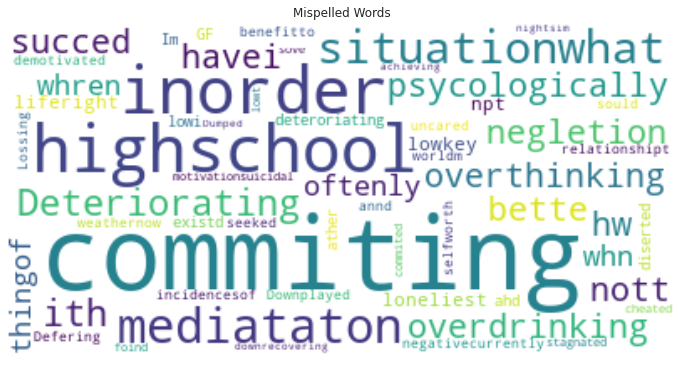

In [ ]:
wordcloud = WordCloud(max_font_size=60, max_words=100, background_color="white").generate(' '.join(mss_2))
plt.figure(figsize=(12, 18))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Mispelled Words')
plt.axis("off");

In [ ]:
blob_corrected = {}
mss_3 = []
for w in tqdm_notebook(mss_2):
  if Word(w).spellcheck()[0][1] >= 0.60:
    correct = TextBlob(w).words[0].correct()
    blob_corrected[w] = correct
  else: mss_3.append(w)

segment_corrected = {}
mss_4 = []
for w in tqdm_notebook(mss_3):
  if len(segment(w)) <= 2:
    segment_corrected[w] = ' '.join(segment(w))
  else:
    mss_4.append(w)

blob_corrected_2 = {}
for w in tqdm_notebook(mss_4):
    correct = TextBlob(w).words[0].correct()
    blob_corrected_2[w] = correct

In [ ]:
all_corrections = {**blob_corrected, **segment_corrected, **blob_corrected_2}

for key, value in tqdm_notebook(all_corrections.items()):
  for i in tqdm_notebook(range(len(comb)), leave = False):
    text_nonpunct = (''.join([char for char in comb.correct.iloc[i] if char not in string.punctuation])).split(' ')
    if key in text_nonpunct:
      corr_txt = [w.replace(key, value) for w in text_nonpunct]
      comb.correct.iloc[i] = ' '.join(corr_txt)

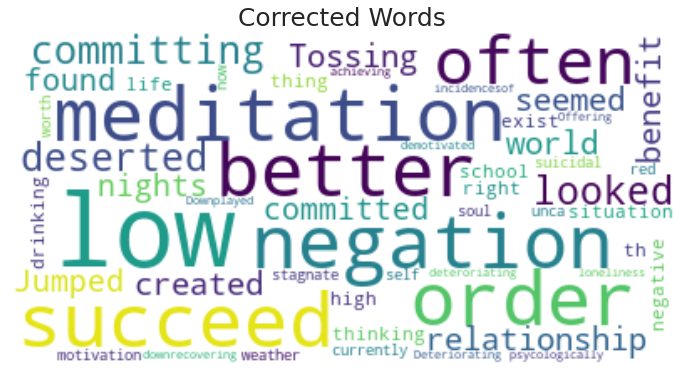

In [ ]:
wordcloud = WordCloud(max_font_size=60, max_words=100, background_color="white").generate(' '.join(all_corrections.values()))
plt.figure(figsize=(12, 18))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Corrected Words', fontsize = 25)
plt.axis("off");

# EDA Analysis

In [ ]:
train = comb[comb.separator == 0]
test = comb[comb.separator == 1]

train.drop('separator', axis = 1, inplace = True)
test.drop('separator', axis = 1, inplace = True)

In [ ]:
# Doing analysis per label
train['label'] = target.copy()
train.label.value_counts()

0    352
1    140
2     66
3     58
Name: label, dtype: int64

## Most frequent words per label

In [ ]:
# Creating a list of words in the depression dataframe
frequent_wrds = {}
for n in tqdm_notebook(range(4)):
  holder = []
  for i in tqdm_notebook(range(len(train[train.label == n])), leave = False):
    text_nonpunct = ''.join([char.lower() for char in train[train.label == n].correct.iloc[i] if char not in string.punctuation])
    tokens = re.split('\W+', text_nonpunct)
    clean_text = [token for token in tokens if token not in stopword]
    lemma = [wn.lemmatize(word) for word in clean_text]
    lemma = [x for x in [singularize(x) for x in lemma] if x != '']
    holder.extend(lemma)
  frequent_wrds[n] = Counter(holder).most_common(10)

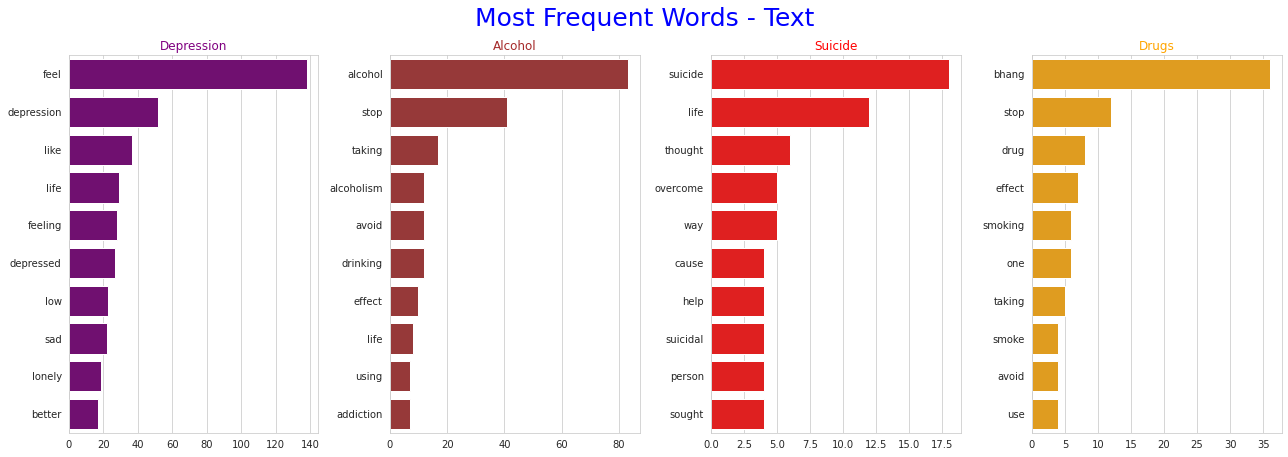

In [ ]:
sns.set_style('whitegrid')
f, axes = plt.subplots(1,4,figsize=(18,6))
sns.barplot(y = [x[0] for x in frequent_wrds.get(0)], x = [x[1] for x in frequent_wrds.get(0)], color = 'purple', ax=axes[0]).set_title('Depression', color = 'purple')
sns.barplot(y = [x[0] for x in frequent_wrds.get(1)], x = [x[1] for x in frequent_wrds.get(1)], color = 'brown', ax=axes[1]).set_title('Alcohol', color = 'brown')
sns.barplot(y = [x[0] for x in frequent_wrds.get(2)], x = [x[1] for x in frequent_wrds.get(2)], color = 'red', ax=axes[2]).set_title('Suicide', color = 'red')
sns.barplot(y = [x[0] for x in frequent_wrds.get(3)], x = [x[1] for x in frequent_wrds.get(3)], color = 'orange', ax=axes[3]).set_title('Drugs', color = 'orange')
plt.suptitle("Most Frequent Words - Text" ,fontsize=25,color="blue", y = 1.05)
plt.tight_layout()

## Adding more weight to key words

In [ ]:
# From the above plots, it can be deduced that certain words are given priority during classification.
# Like depression, alcohol, drink, suicide, drugs and bhang
# To give prevalance to this most frequent words, more weight should be given the words during modelling.
# Therefore if a most frequent/key word exists, its conjugate, lexeme, comparative, superlative, pluralize, singularize is added the text
# For example if you add weight to drink, it returns ['drinking', 'drank', 'drinker', 'drink', 'drunk', 'drinks', 'drinkest']
# Creating a new dataframe containing the new added words

# Creating a function that adds the weighted words
def add_weight(word):
  aspect = [x for x in [conjugate(word, aspect = i) for i in ['imperative', 'perfective', 'progressive']] if x is not None]
  mood = [x for x in [conjugate(word, mood = i) for i in ['indicative', 'imperative', 'conditional', 'subjunctive']] if x is not None]
  tense = [x for x in [conjugate(word, tense = i) for i in ['infinitive', 'present', 'past', 'future']] if x is not None]
  weights = list(set(lexeme(word)+[comparative(word)]+[superlative(word)]+[pluralize(word)]+[singularize(word)]+aspect+mood+tense))
  return weights

weighted_df = comb.copy()
weighted = {}
for i in tqdm_notebook(range(len(weighted_df)), leave = False):
  text_nonpunct = ''.join([char.lower() for char in weighted_df.correct.iloc[i] if char not in string.punctuation])
  tokens = re.split('\W+', text_nonpunct)
  clean_text = [token for token in tokens if token not in stopword]
  lemma = [(wn.lemmatize(word)).strip() for word in clean_text]
  if ('suicide' in lemma)|('suicidal' in lemma)|('pill' in lemma)|('stress' in lemma): weighted[i] = ' '.join(lemma+add_weight('suicide'))
  elif ('depression' in lemma)|('depressed' in lemma): weighted[i] = ' '.join(lemma+add_weight('depression'))
  elif ('drink' in lemma)|('alcohol' in lemma)|('drunkard'in lemma): weighted[i] = ' '.join(lemma+add_weight('alcohol'))
  elif ('bhang' in lemma)|('smoke' in lemma): weighted[i] = ' '.join(lemma+add_weight('bhang'))

for i in tqdm_notebook(range(len(weighted_df)), leave = False):
  if i in weighted.keys():
    weighted_df.correct.iloc[i] = weighted.get(i)

# Remove overfitting word : feel
for i in tqdm_notebook(range(len(weighted_df)), leave = False):
  text_nonpunct = ''.join([char.lower() for char in weighted_df.correct.iloc[i] if char not in string.punctuation])
  tokens = re.split('\W+', text_nonpunct)
  clean_text = [token for token in tokens if token not in stopword]
  lemma = [wn.lemmatize(word) for word in clean_text]
  lemma = [x for x in lemma if x not in add_weight('feel')]
  weighted_df.correct.iloc[i] = ' '.join(lemma)

In [ ]:
w_train = weighted_df[weighted_df.separator == 0]
w_test = weighted_df[weighted_df.separator == 1]

w_train.drop(['separator', 'ID', 'text'], axis = 1, inplace = True)
w_test.drop(['separator', 'ID', 'text'], axis = 1, inplace = True)

# Pseudo Labelling

### Model 1 - XGBoost with CountVectorizer

In [ ]:
# https://en.wikipedia.org/wiki/Semi-supervised_learning
# https://www.kaggle.com/cdeotte/pseudo-labeling-qda-0-969
'''
Pseudo labeling is the process of adding confident predicted test data to your training data. Pseudo labeling is a 5 step process.
1. Build a model using training data.
2. Predict labels for an unseen test dataset.
3. Add confident predicted test observations to our training data
4. Build a new model using combined data.
5. Use the new model to predict the test data
'''

vect = CountVectorizer()
X =vect.fit_transform(w_train['correct'])
y = target.copy()
tes = vect.transform(w_test['correct'])

preds = []
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
for train_index, test_index in tqdm_notebook(kfold.split(X, y)):
  X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
  xgb = XGBClassifier()
  xgb.fit(X_train, y_train)
  preds.append(xgb.predict_proba(tes))
predictions = np.mean(preds, 0)

pseudo = {}
for i in tqdm_notebook(range(len(predictions))):
  index = np.argmax(predictions[i])
  prob = np.max(predictions[i])
  if (index == 0) & (prob >= 0.95): pseudo[i] = 0
  elif (index == 1) & (prob >= 0.95): pseudo[i] = 1
  elif (index == 2) & (prob >= 0.5): pseudo[i] = 2
  elif (index == 3) & (prob >= 0.7): pseudo[i] = 3

pseudo_df = test.loc[pseudo.keys()]
pseudo_df['label'] = pseudo.values()
new_train = pd.concat([train, pseudo_df]).reset_index(drop = True)

In [ ]:
train.shape, new_train.shape, pseudo_df.shape[0], new_train.shape[0] - train.shape[0]

((616, 4), (742, 4), 126, 126)

In [ ]:
new_train = new_train.drop(['ID', 'text'], axis = 1)

# Roberta Large Model 1

In [ ]:
%%time
err=[]
y_pred_tot=[]

fold=StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
i=1
for train_index, test_index in tqdm(fold.split(new_train,new_train['label']), desc = 'Fold:'):
    new_train_trn, new_train_val = new_train.iloc[train_index], new_train.iloc[test_index]
    model = ClassificationModel('roberta', 'roberta-large', use_cuda=True,num_labels=4, args={'train_batch_size':16,
                                                                         'reprocess_input_data': True,
                                                                         'overwrite_output_dir': True,
                                                                         'fp16': False,
                                                                         'do_lower_case': False,
                                                                         'num_train_epochs': 4,
                                                                         'max_seq_length': 16,
                                                                         'regression': False,
                                                                         'manual_seed': 2,
                                                                         "learning_rate":2e-5,
                                                                         'weight_decay':0,
                                                                         "save_eval_checkpoints": False,
                                                                         "save_model_every_epoch": False,
                                                                         "silent": True})
    model.train_model(new_train_trn)
    raw_outputs_val = model.eval_model(new_train_val)[1]
    raw_outputs_val = softmax(raw_outputs_val,axis=1)
    print(f"Log_Loss: {log_loss(new_train_val['label'], raw_outputs_val)}")
    err.append(log_loss(new_train_val['label'], raw_outputs_val))
    raw_outputs_test = model.eval_model(test1)[1]
    raw_outputs_test = softmax(raw_outputs_test,axis=1)
    y_pred_tot.append(raw_outputs_test)
print("Mean LogLoss: ", np.mean(err))
# ep4_bs16_sl64_lr3e-05 0.36361354025166104
preds=np.mean(y_pred_tot, 0)
sub_df = pd.DataFrame(preds, columns = ['Depression', 'Alcohol', 'Suicide', 'Drugs'])
sub_df['ID'] = test.ID
sub_df = sub_df[['ID', 'Depression', 'Alcohol', 'Suicide', 'Drugs']]
sub_df.to_csv('robbertaa_3.csv', index = False)




Fold:: 0it [00:00, ?it/s]

Log_Loss: 0.2861716862792937





Fold:: 1it [00:57, 57.07s/it]

Log_Loss: 0.4388934400865508





Fold:: 2it [01:53, 56.76s/it]

Log_Loss: 0.39605272437187816





Fold:: 3it [02:47, 56.19s/it]

Log_Loss: 0.28924561530112514





Fold:: 4it [03:44, 56.26s/it]

Log_Loss: 0.4036015500943806





Fold:: 5it [04:40, 56.04s/it]

Mean LogLoss:  0.36279300322664565
CPU times: user 2min 53s, sys: 1min 5s, total: 3min 58s
Wall time: 4min 40s
